In [20]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [19]:
from IPython.display import Image
Image(url='../PwNY.gif', width = 900)

# Introduction

<p>In this notebook, we will use Kaggle Advance House Problem to predict the price of a house based on its features. 

Just based on our intuition, first thing that comes to my mind is that houses with more square footage will be more costly than houses with less square footage. When I think harder, I realize that a 1000sq ft house in Boston downtown is not the same price as a 1000sq ft house in Greater Boston area. The complexity of the problem lies in various factors interacting with one another.</p>

<p>I will in this notebook analyze factors that contribute in estimating a price of a house. Few factors that I think we play significant role in house predictions are below</p>
<li>Square Footage</li>
<li>Locality</li>
<li>Proximity to schools</li>
<li>No. of rooms</li>
<li>Amneties</li>

<h3>Importing the packages needed for data analysis, regressor building and viz.</h3>

In [21]:
# Loading the packages needed
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
print('package have been loaded...')

package have been loaded


<h3>Loading the datasets</h4>

In [38]:
# Loading the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# Saving the train id and the test id
train_id = train['Id']
test_id = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
print('Id field has been dropped')
print('Trainset Shape', train.shape)
print('Train/Test are loaded...')

Id field has been dropped
Trainset Shape (1460, 80)
Train/Test are loaded...


In [37]:
# Building a simple model using selected features
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h3>Imputing the missing features</h3>

In [69]:
count_miss_data = train.isnull().sum()
count_miss_data = count_miss_data[count_miss_data!=0]

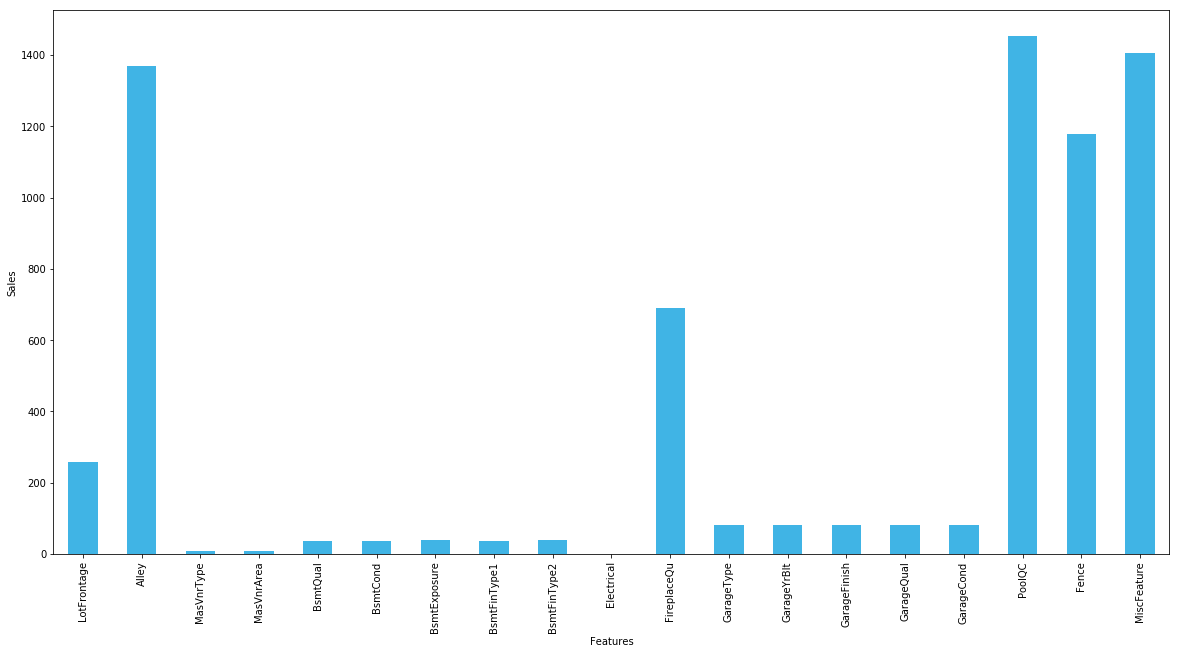

In [80]:
plt.subplots(figsize =(20, 10))
count_miss_data.plot(kind='bar', color='#40b4e5')
plt.xlabel('Features')
plt.ylabel('Sales')
plt.show()